In [1]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append(r'/mnt/s/_Data/160513 - EonHe M016v5/modules')
    from BEM import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


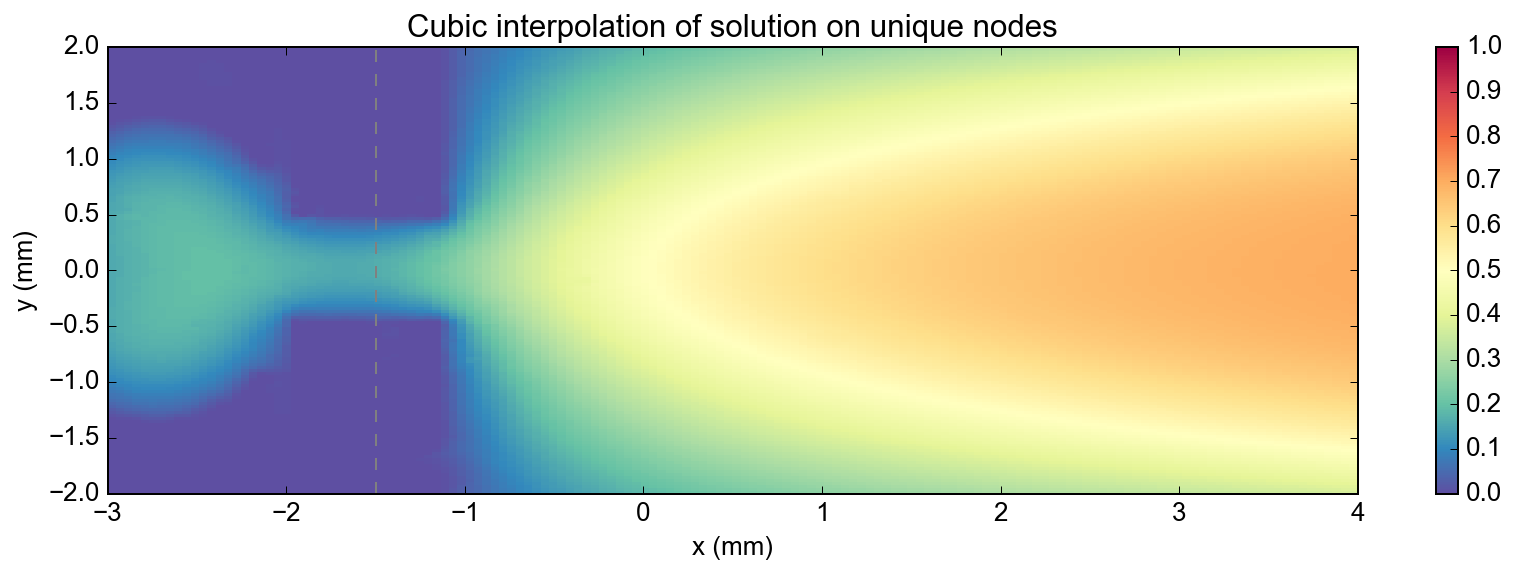

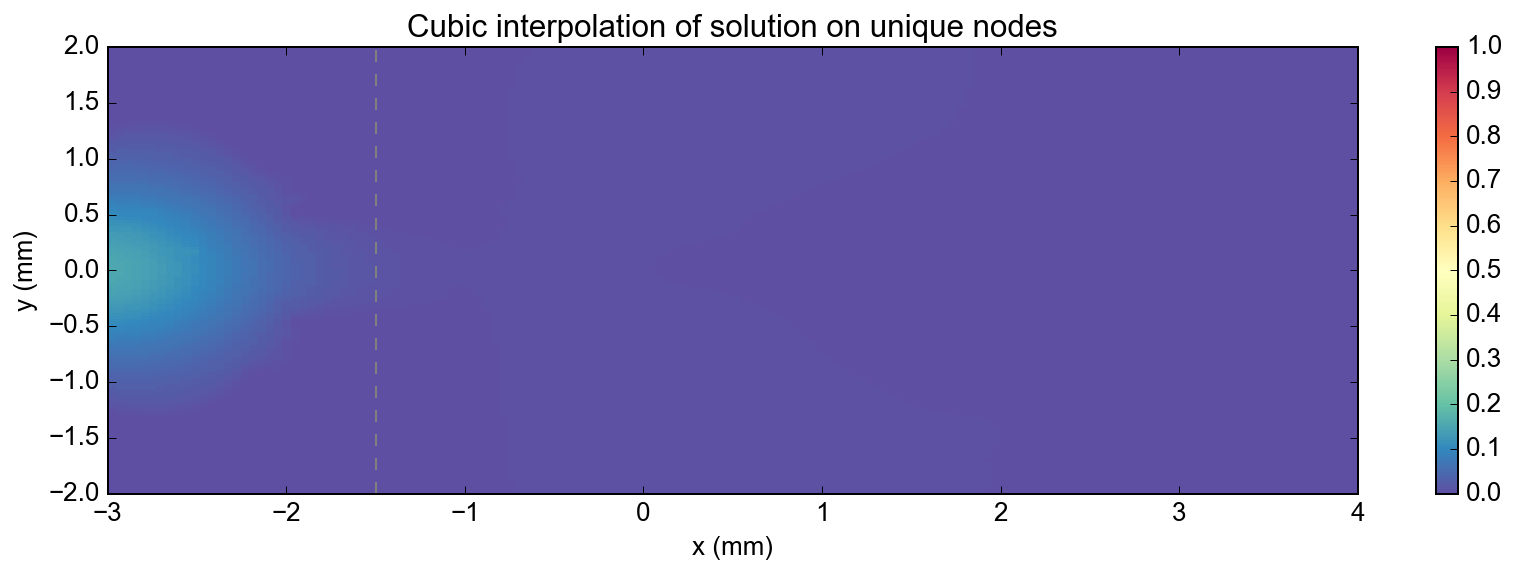

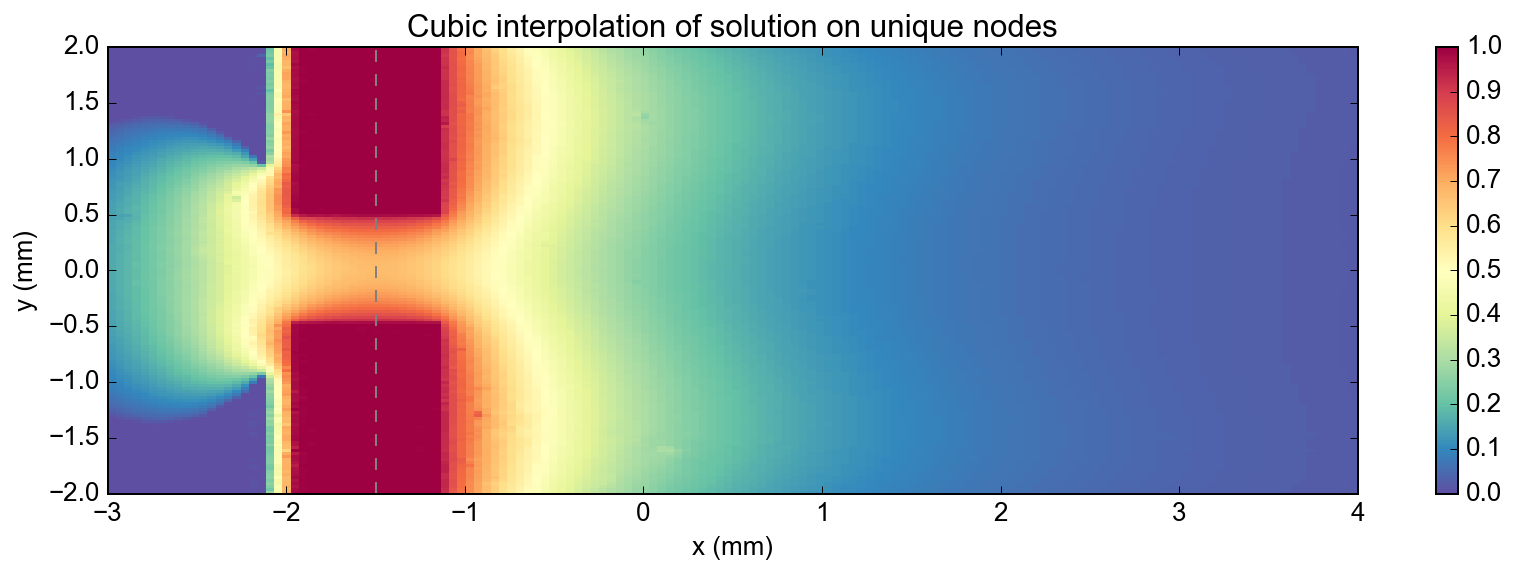

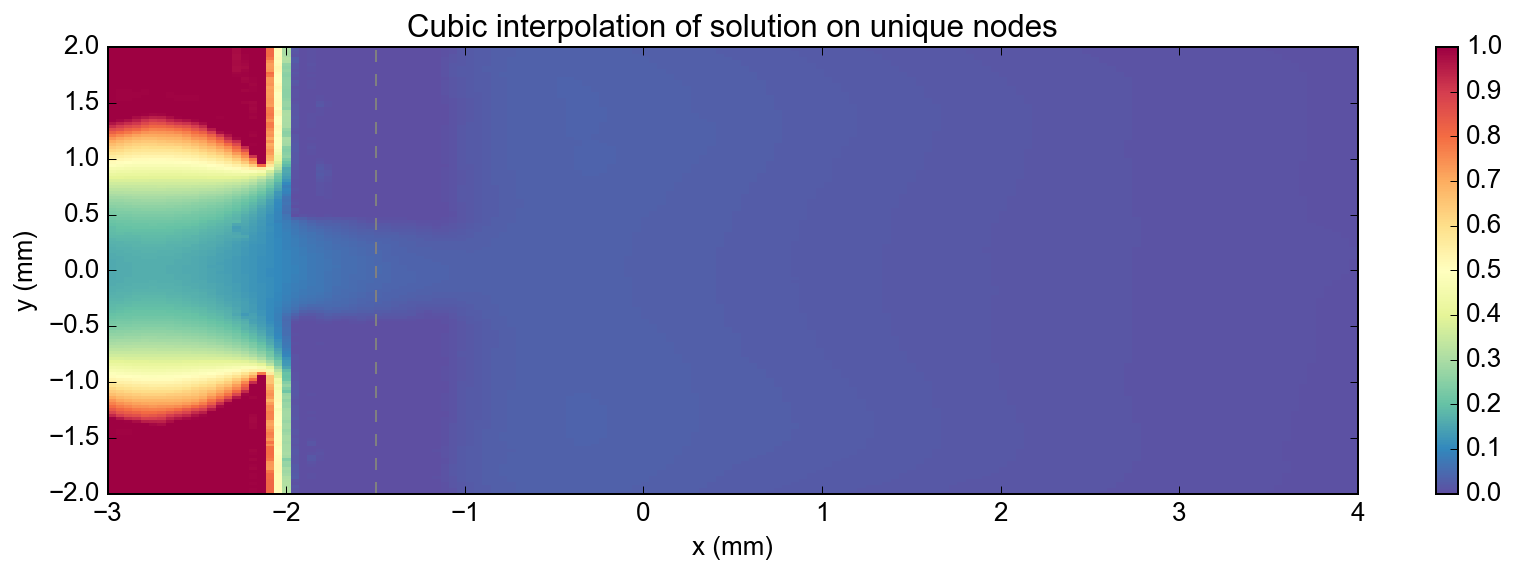

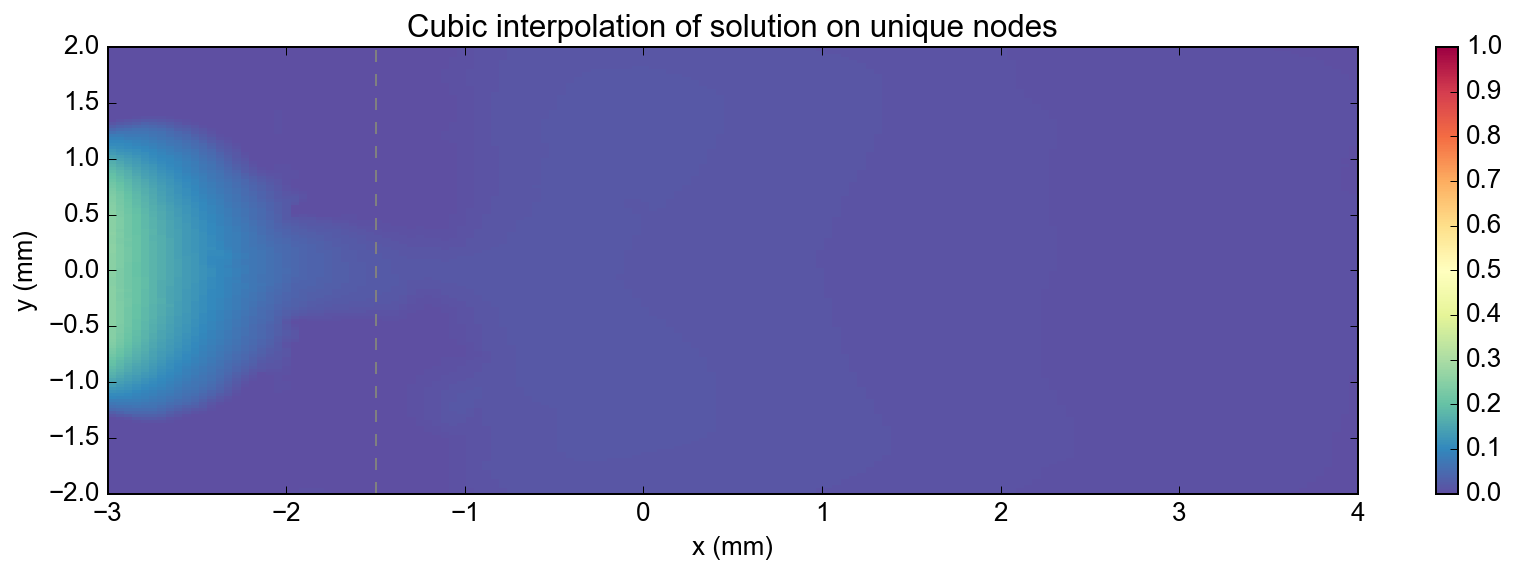

In [52]:
# Evaluate all files in the range
xeval=np.linspace(-3, 4, 151)
yeval = np.linspace(-2, 2, 151)


datafiles = ["..\\Maxwell\\M016v6 Greater Trap Area\\Resonator.dsp",
             "..\\Maxwell\\M016v6 Greater Trap Area\\Trap.dsp",
             "..\\Maxwell\\M016v6 Greater Trap Area\\ResonatorGuard.dsp",
             "..\\Maxwell\\M016v6 Greater Trap Area\\CenterGuard.dsp", 
             "..\\Maxwell\\M016v6 Greater Trap Area\\TrapGuard.dsp"]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(14.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=(0, 1.0), 
                                                         plot_axes='xy', cmap=plt.cm.Spectral_r, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})
    
    plt.vlines(-1.5, -2.0, 2.0, linestyles="--", color="gray")

In [53]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

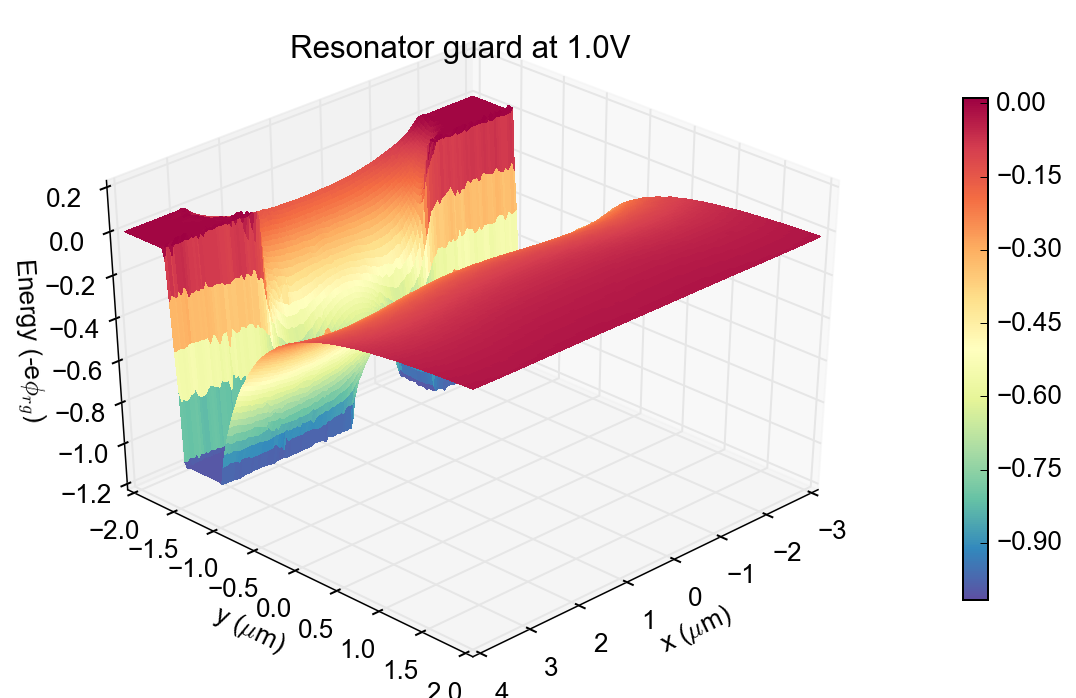

In [54]:
fig = plt.figure(figsize=(10.,6.))
common.configure_axes(13)
ax = fig.gca(projection='3d')

Xm, Ym = meshgrid(xeval, yeval)
Zm = output[2]['V']

surf = ax.plot_surface(Xm, Ym, -Zm, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
ax.set_zlabel("Energy (-e$\phi_{rg}$)")
ax.view_init(elev=35., azim=+45)
ax.set_title("Resonator guard at 1.0V")

fig.colorbar(surf, shrink=0.75, aspect=20)

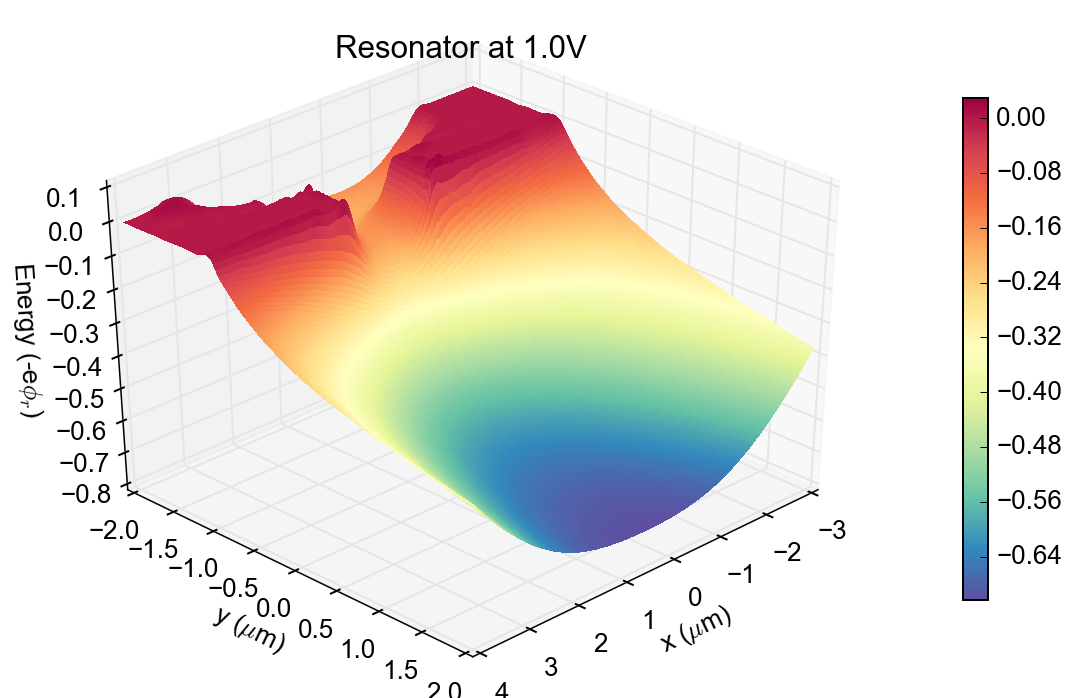

In [55]:
fig = plt.figure(figsize=(10.,6.))
common.configure_axes(13)
ax = fig.gca(projection='3d')

Xm, Ym = meshgrid(xeval, yeval)
Zm = output[0]['V']

surf = ax.plot_surface(Xm, Ym, -Zm, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
ax.set_zlabel("Energy (-e$\phi_r$)")

ax.view_init(elev=35., azim=+45)
ax.set_title("Resonator at 1.0V")

fig.colorbar(surf, shrink=0.75, aspect=20)

# How strong do electrodes contribute to barrier potential $V_b$?

We would like to describe the potential at the barrier in terms of the resonator voltage $V_r$ and the resonator guard $V_{rg}$: 

$$ V_b = \alpha V_r + \beta V_{rg} $$

To find $\alpha$ and $\beta$ let's plot the energy across the channel when 1V is applied to each of the electrodes:

alpha = 0.167
beta = 0.011
gamma = 0.671
delta = 0.047
epsilon = 0.021


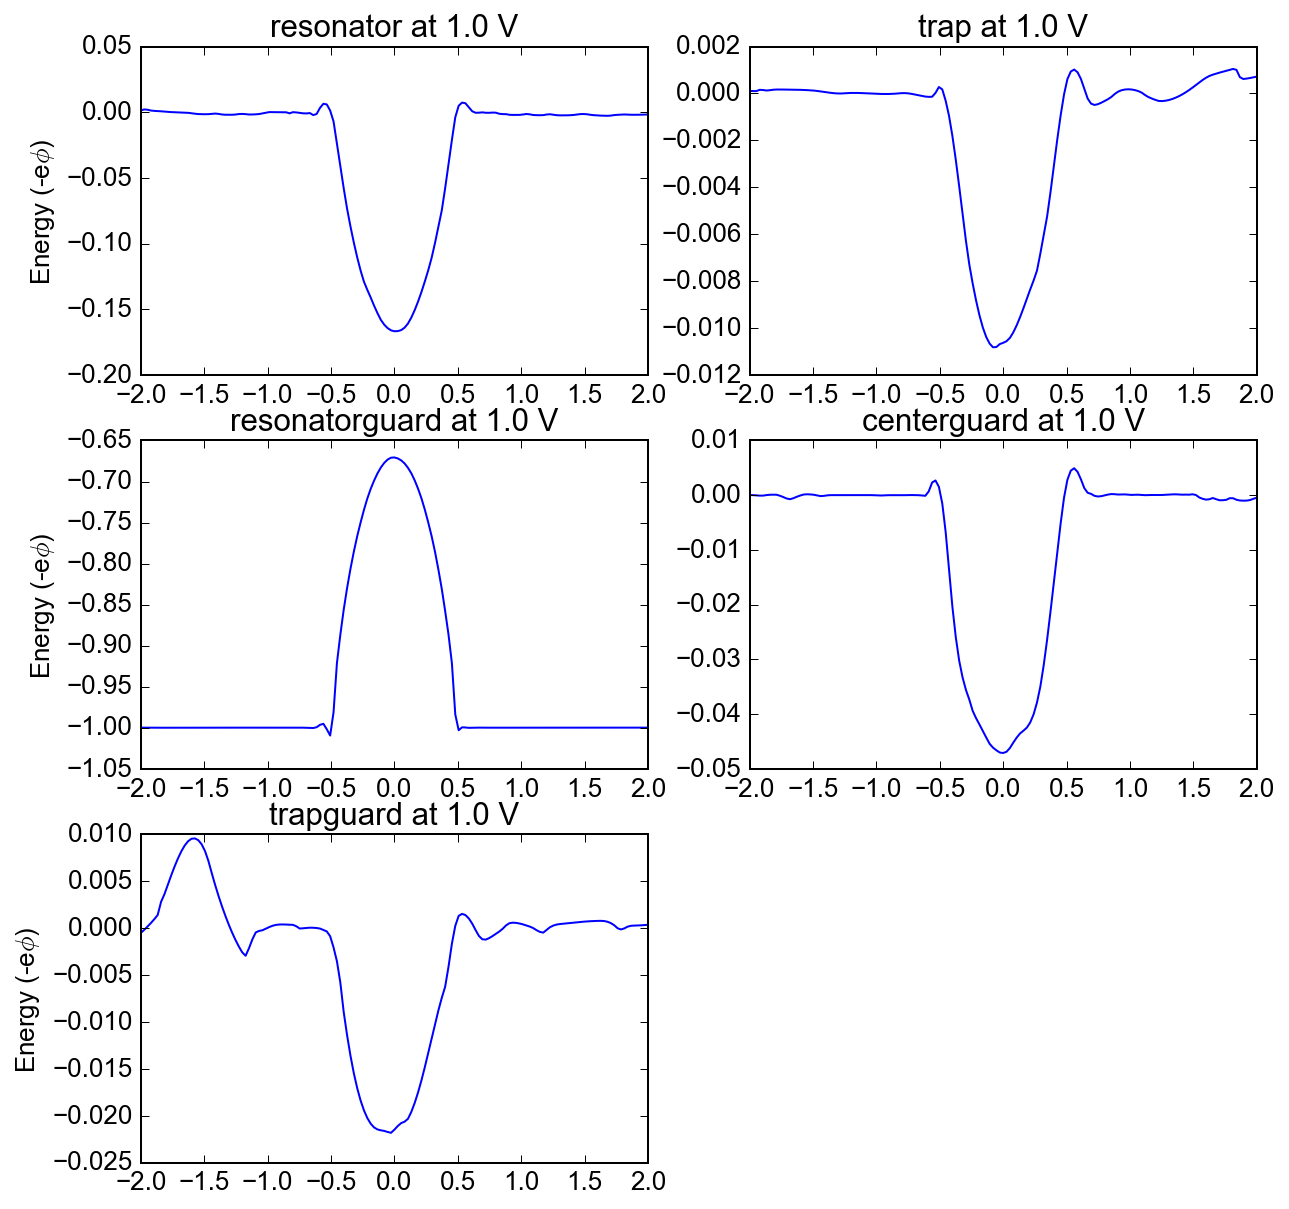

In [103]:
xoi = -1.5
xoi_idx = common.find_nearest(xeval, xoi)
ctr_idx = common.find_nearest(yeval, 0)

names = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']

plt.figure(figsize=(10.,10.))
    
for i in range(5):
    plt.subplot("32%d"%(i+1))
    plt.plot(yeval, -output[i]['V'][xoi_idx,:])
    if not i%2:
        plt.ylabel("Energy (-e$\phi$)")
    #if i in [4,5]:
    #    plt.xlabel("x ($\mu$m)")
    plt.title("%s at 1.0 V"%output[i]['name'])

    print "%s = %.3f"%(names[i], output[i]['V'][xoi_idx,ctr_idx])

And so it follows that to good approximation we can neglect all but the resonator and the resonator guard electrode: $V_b = 0.17 V_r + 0.67 V_{rg}$. 
This makes sense, since the resonator guard should have much more influence on the barrier than the resonator. The resonator is further away from the point at which we measure the potential. 

For the electron potential $V_e$, we need to look at the reservoir, in this case the resonator. Let's take a look at a cut across the channel and determine $\gamma$ in

$$ V_e = \gamma V_r - \frac{e n_s d}{\epsilon \epsilon_0} $$

gamma = 0.70


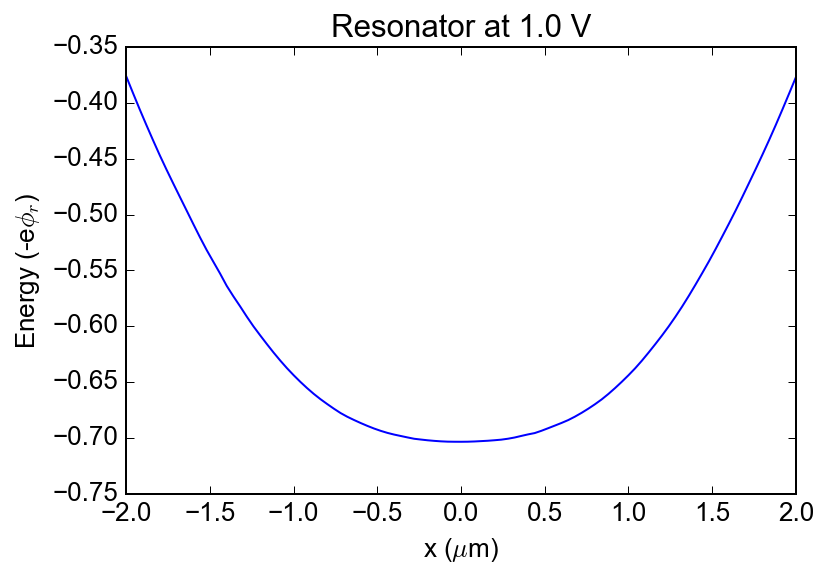

In [47]:
xoi = +4.0
xoi_idx = common.find_nearest(xeval, xoi)
ctr_idx = common.find_nearest(yeval, 0)

plt.figure(figsize=(6.,4.))
plt.plot(yeval, -output[0]['V'][xoi_idx,:])
plt.ylabel("Energy (-e$\phi_r$)")
plt.xlabel("x ($\mu$m)")
plt.title("Resonator at 1.0 V")

print "gamma = %.2f"%(output[0]['V'][xoi_idx,ctr_idx])

And so it follows that 

$$ V_e = 0.70 V_r - \frac{e n_s d}{\epsilon \epsilon_0} = 0.70 V_r - \Delta V$$

Now we're able to make an energy diagram, plotting $-eV_e$ and $-eV_b$ as a function of $V_r$ and $V_{rg}$ 

# Example of combined potential landscape 

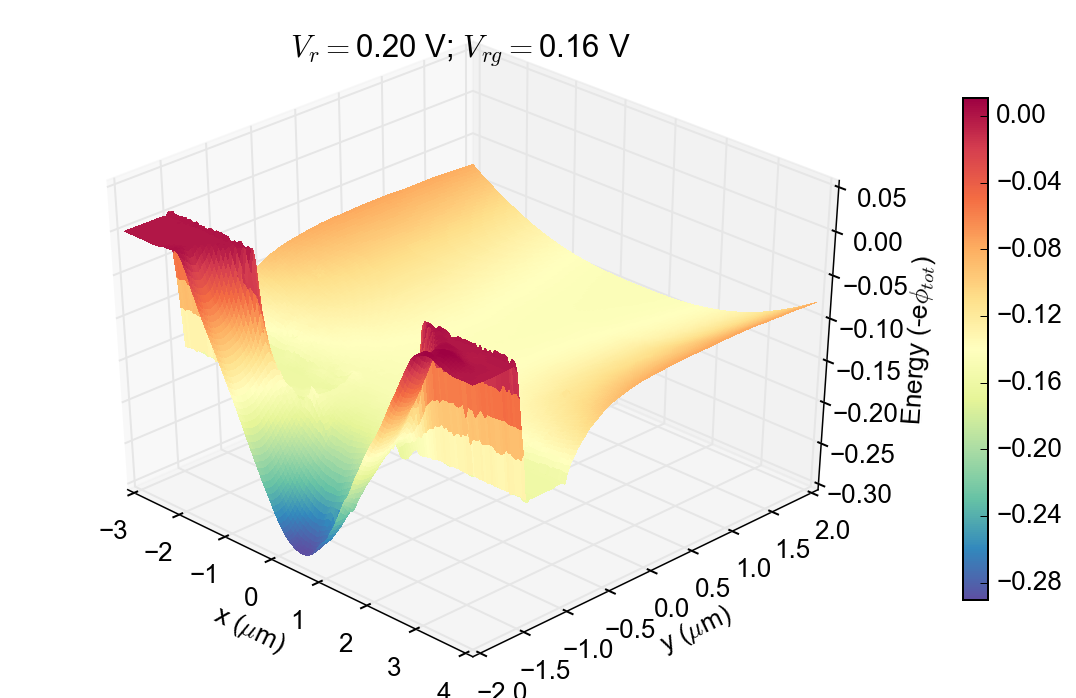

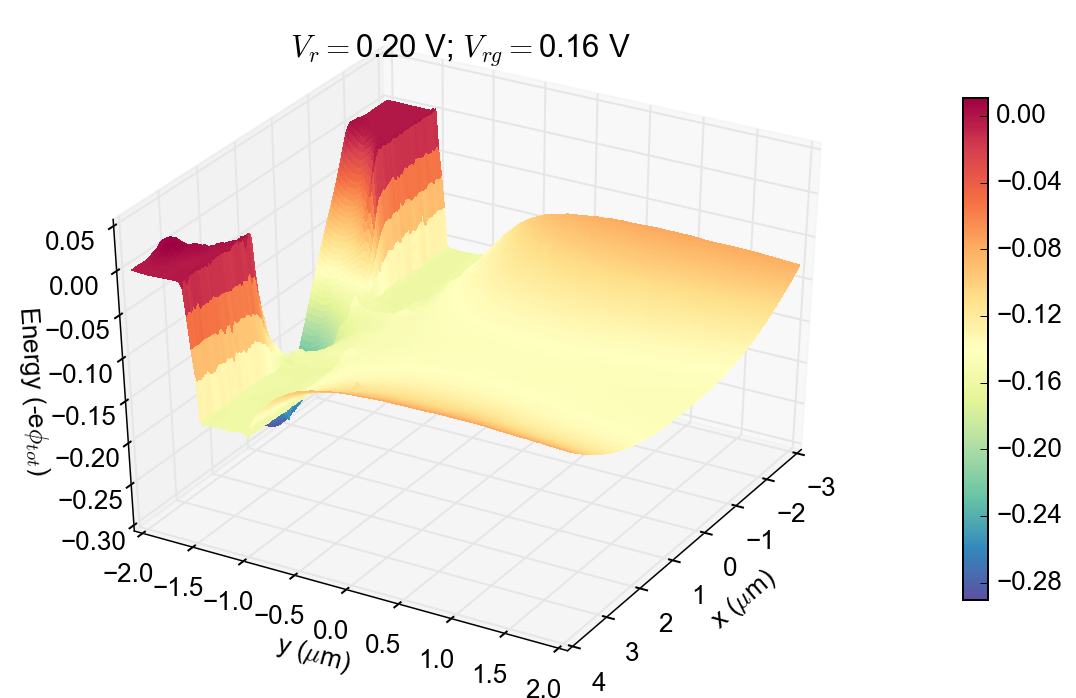

In [89]:
Xm, Ym = meshgrid(xeval, yeval)
Vr = output[0]['V']
Vrg = output[2]['V']
Vt = output[1]['V']

Vr_coef = 0.20
Vrg_coef = 0.16

Zm = Vr_coef * Vr + Vrg_coef * Vrg + 1.5 * Vt

for view_angle in [-45, 30]:
    fig = plt.figure(figsize=(10.,6.))
    common.configure_axes(13)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Xm, Ym, -Zm, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                           linewidth=0, antialiased=False)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_zlabel("Energy (-e$\phi_{tot}$)")
    ax.view_init(elev=35., azim=view_angle)
    fig.colorbar(surf, shrink=0.75, aspect=20)
    plt.title("$V_r = $%.2f V; $V_{rg} = $%.2f V"%(Vr_coef, Vrg_coef))
    
    common.save_figure(fig, save_path="..\\Maxwell\\M016v6 Greater Trap Area")

# Expected successful loading conditions

Loading should be successful when $-eV_e > -e V_b$. In terms of the separate electrodes, we have

$$ -e\gamma V_r + \frac{e^2 n_s d}{\epsilon \epsilon_0} > -e\alpha V_r -e\beta V_{rg}  $$

Rewriting this for $n_s$, we get

$$ n_s > \frac{\epsilon \epsilon_0}{e d} \left( (\gamma-\alpha) V_r -\beta V_{rg} \right)$$

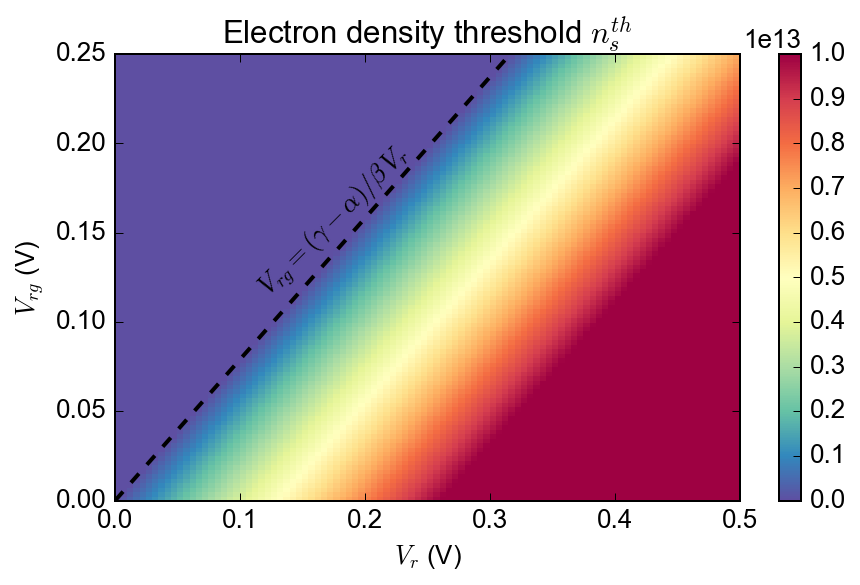

In [81]:
c = trap_analysis.get_constants()
helium_depth = 800E-9
alpha = 0.17
beta = 0.67
gamma = 0.70

vr = np.linspace(0., 0.5, 101)
vrg = np.linspace(0., 0.25, 101)

VR, VRG = np.meshgrid(vr, vrg)
NS_TH = 1.056 * c['eps0']/(c['e'] * helium_depth) * ((gamma - alpha)*VR - beta*VRG)
NS_TH[NS_TH < 0] = 0
NS_TH[NS_TH > 1E13] = 1E13

fig = plt.figure(figsize=(7.,4.))
plt.pcolormesh(VR, VRG, NS_TH, cmap=plt.cm.Spectral_r)
plt.plot(vr, (gamma-alpha)/beta * vr, '--k', lw=2.0)
plt.xlabel('$V_r$ (V)')
plt.ylabel('$V_{rg}$ (V)')
plt.title("Electron density threshold $n_s^{th}$")
plt.ylim(np.min(vrg), np.max(vrg))
plt.text(0.11, 0.11, r"$V_{rg} = (\gamma-\alpha)/\beta \,V_r$", rotation=45, ha='left', va='bottom')
plt.colorbar()

#common.save_figure(fig, save_path="..\\Maxwell\\M016v6 Greater Trap Area")